# Bitcoin Time Series Prediction with LSTM

Purpose is to try and predict the prices of bitcoin with univariate and multivariate LSTM

#### Import necessary library needed for the model training

In [614]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

#### Use Quandl api to get BTC/USD data from kraken exchange

In [615]:
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

#### Read data set

In [381]:
# data = pd.read_csv(filepath_or_buffer="./BTCUSDKRAKEN", index_col="Date")

#### View data info

In [616]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1384 entries, 2014-01-07 to 2017-10-21
Data columns (total 7 columns):
Open                 1384 non-null float64
High                 1384 non-null float64
Low                  1384 non-null float64
Close                1384 non-null float64
Volume (BTC)         1384 non-null float64
Volume (Currency)    1384 non-null float64
Weighted Price       1384 non-null float64
dtypes: float64(7)
memory usage: 86.5 KB


#### View data rows

In [617]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


#### Check latest date of data

In [618]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-10-17,5738.7,5759.9,5535.1,5606.5,3462.553479,1.947659e+07,5624.919714
2017-10-18,5606.5,5630.0,5132.3,5579.4,6192.789612,3.340670e+07,5394.451775
2017-10-19,5590.0,5731.3,5534.0,5695.3,3450.458951,1.948298e+07,5646.489531
2017-10-20,5703.1,6050.0,5620.0,5999.0,4449.033282,2.617186e+07,5882.595020
2017-10-21,5990.2,6180.0,5920.9,6093.0,4315.852868,2.620906e+07,6072.741540


#### Plot line graph base on `Weighted Price`

In [619]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

#### Fill value 0 data points on `Weighted Price` with NAN and then use ffill method to fill values

In [620]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

#### Plot new line graph again on `Weighted Price` with newly filled values

In [621]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

### Using `Weighted Price` as a feature to train the LSTM model 

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [622]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Split 70% of data for training and 30% for testing

In [669]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

(968, 416)


#### Create function for creating dataset with look back

In [670]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [671]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

967
415


In [672]:
print(trainX[:5])
print(trainY[:5])

[[ 0.10934697]
 [ 0.10889077]
 [ 0.10759959]
 [ 0.10987535]
 [ 0.11766218]]
[ 0.10889077  0.10759959  0.10987535  0.11766218  0.11251724]


#### Reshape X for model training

In [673]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Running the LSTM model with 300 epochs

In [674]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=300, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 967 samples, validate on 415 samples
Epoch 1/500
3s - loss: 0.0330 - val_loss: 0.2585
Epoch 2/500
0s - loss: 0.0246 - val_loss: 0.2420
Epoch 3/500
0s - loss: 0.0214 - val_loss: 0.2289
Epoch 4/500
0s - loss: 0.0219 - val_loss: 0.2197
Epoch 5/500
0s - loss: 0.0230 - val_loss: 0.2141
Epoch 6/500
0s - loss: 0.0237 - val_loss: 0.2109
Epoch 7/500
0s - loss: 0.0237 - val_loss: 0.2094
Epoch 8/500
0s - loss: 0.0232 - val_loss: 0.2088
Epoch 9/500
0s - loss: 0.0225 - val_loss: 0.2086
Epoch 10/500
0s - loss: 0.0218 - val_loss: 0.2086
Epoch 11/500
0s - loss: 0.0210 - val_loss: 0.2087
Epoch 12/500
0s - loss: 0.0203 - val_loss: 0.2084
Epoch 13/500
0s - loss: 0.0198 - val_loss: 0.2074
Epoch 14/500
0s - loss: 0.0195 - val_loss: 0.2057
Epoch 15/500
0s - loss: 0.0194 - val_loss: 0.2035
Epoch 16/500
0s - loss: 0.0192 - val_loss: 0.2009
Epoch 17/500
0s - loss: 0.0192 - val_loss: 0.1982
Epoch 18/500
0s - loss: 0.0191 - val_loss: 0.1956
Epoch 19/500
0s - loss: 0.0190 - val_loss: 0.1934
Epoch 20/500


0s - loss: 0.0016 - val_loss: 0.0132
Epoch 169/500
0s - loss: 0.0015 - val_loss: 0.0133
Epoch 170/500
0s - loss: 0.0015 - val_loss: 0.0133
Epoch 171/500
0s - loss: 0.0015 - val_loss: 0.0133
Epoch 172/500
0s - loss: 0.0016 - val_loss: 0.0132
Epoch 173/500
0s - loss: 0.0015 - val_loss: 0.0133
Epoch 174/500
0s - loss: 0.0015 - val_loss: 0.0133
Epoch 175/500
0s - loss: 0.0016 - val_loss: 0.0131
Epoch 176/500
0s - loss: 0.0015 - val_loss: 0.0131
Epoch 177/500
0s - loss: 0.0015 - val_loss: 0.0131
Epoch 178/500
0s - loss: 0.0016 - val_loss: 0.0131
Epoch 179/500
0s - loss: 0.0015 - val_loss: 0.0131
Epoch 180/500
0s - loss: 0.0016 - val_loss: 0.0130
Epoch 181/500
0s - loss: 0.0016 - val_loss: 0.0130
Epoch 182/500
0s - loss: 0.0015 - val_loss: 0.0130
Epoch 183/500
0s - loss: 0.0016 - val_loss: 0.0129
Epoch 184/500
0s - loss: 0.0015 - val_loss: 0.0129
Epoch 185/500
0s - loss: 0.0015 - val_loss: 0.0130
Epoch 186/500
0s - loss: 0.0016 - val_loss: 0.0129
Epoch 187/500
0s - loss: 0.0015 - val_loss: 0

0s - loss: 0.0016 - val_loss: 0.0097
Epoch 334/500
0s - loss: 0.0015 - val_loss: 0.0097
Epoch 335/500
0s - loss: 0.0015 - val_loss: 0.0097
Epoch 336/500
0s - loss: 0.0016 - val_loss: 0.0096
Epoch 337/500
0s - loss: 0.0016 - val_loss: 0.0096
Epoch 338/500
0s - loss: 0.0015 - val_loss: 0.0096
Epoch 339/500
0s - loss: 0.0016 - val_loss: 0.0096
Epoch 340/500
0s - loss: 0.0015 - val_loss: 0.0096
Epoch 341/500
0s - loss: 0.0015 - val_loss: 0.0096
Epoch 342/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 343/500
0s - loss: 0.0016 - val_loss: 0.0094
Epoch 344/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 345/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 346/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 347/500
0s - loss: 0.0015 - val_loss: 0.0096
Epoch 348/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 349/500
0s - loss: 0.0016 - val_loss: 0.0094
Epoch 350/500
0s - loss: 0.0016 - val_loss: 0.0094
Epoch 351/500
0s - loss: 0.0015 - val_loss: 0.0094
Epoch 352/500
0s - loss: 0.0016 - val_loss: 0

0s - loss: 0.0016 - val_loss: 0.0087
Epoch 500/500
0s - loss: 0.0016 - val_loss: 0.0087


#### Plot line graph to show amount loss according the the epoch

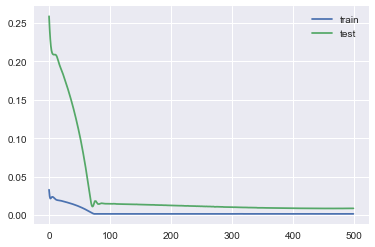

In [675]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

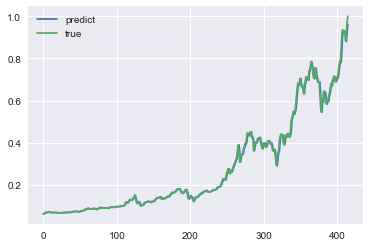

(415, 1)


In [676]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()
print yhat.shape

#### Scaler Inverse Y back to normal value

In [677]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

#### RMSE

In [678]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 89.289


#### Plot line graph with Y as USD

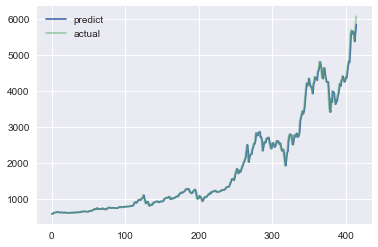

In [679]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Convert X to dates

In [680]:
predictDates = data.tail(len(testX)).index

#### Reshape testY and yhat for plotly

In [681]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [682]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

### Using additional features for model training

#### Create one new feature: Difference of `Weighted Price`

In [599]:
difference = np.diff(data['Weighted Price'])
difference = np.insert(difference, 0, 0)
data['Difference'] = difference
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Difference
Date,,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522,0.000000
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269,-2.679253
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913,-7.583357
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794,13.365881
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709,45.732916


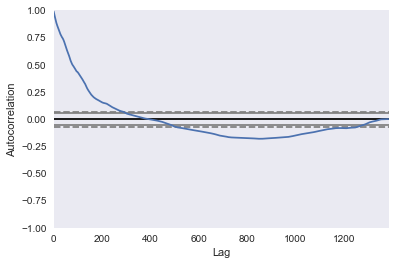

In [600]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Weighted Price'])

#### Find corrleration in features to `Weighted Price`

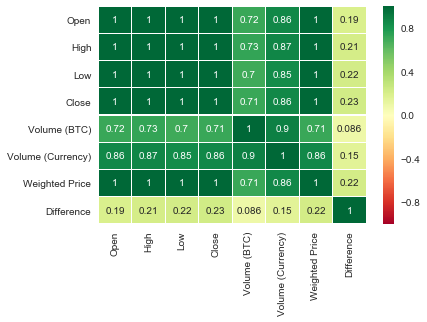

In [601]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=-1)

Observation: `Volume` is corrlerated to `Weighted Price`. 
`Open`, `High`, `Low`, `Close` are directly related to `Weighted Price`

#### Function to convert series to supervised learning

In [602]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Get all data values

In [683]:
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')

#### Normalize features to range from 0 to 1

In [684]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Frame as supervised learning

In [685]:
reframed = series_to_supervised(scaled, 1)
reframed.head()

,var1(t-1),var1(t)
1,0.109347,0.108891
2,0.108891,0.107600
3,0.107600,0.109875
4,0.109875,0.117662
5,0.117662,0.112517


#### Drop columns `Open`, `High`, `Low`, `Close`

In [606]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.109347   0.000715   0.000177  0.108891
2   0.108891   0.000878   0.000216  0.107600
3   0.107600   0.000373   0.000091  0.109875
4   0.109875   0.000367   0.000091  0.117662
5   0.117662   0.000858   0.000225  0.112517


#### Split data to 70% training, 30% testing

In [686]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((968, 1, 1), (968,), (415, 1, 1), (415,))


#### Training the LSTM model with 300 epochs

In [687]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=500, batch_size=300, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 968 samples, validate on 415 samples
Epoch 1/500
3s - loss: 0.0340 - val_loss: 0.2671
Epoch 2/500
0s - loss: 0.0254 - val_loss: 0.2502
Epoch 3/500
0s - loss: 0.0222 - val_loss: 0.2371
Epoch 4/500
0s - loss: 0.0227 - val_loss: 0.2279
Epoch 5/500
0s - loss: 0.0239 - val_loss: 0.2223
Epoch 6/500
0s - loss: 0.0245 - val_loss: 0.2192
Epoch 7/500
0s - loss: 0.0245 - val_loss: 0.2176
Epoch 8/500
0s - loss: 0.0240 - val_loss: 0.2170
Epoch 9/500
0s - loss: 0.0233 - val_loss: 0.2168
Epoch 10/500
0s - loss: 0.0225 - val_loss: 0.2169
Epoch 11/500
0s - loss: 0.0217 - val_loss: 0.2169
Epoch 12/500
0s - loss: 0.0210 - val_loss: 0.2165
Epoch 13/500
0s - loss: 0.0205 - val_loss: 0.2155
Epoch 14/500
0s - loss: 0.0202 - val_loss: 0.2137
Epoch 15/500
0s - loss: 0.0201 - val_loss: 0.2114
Epoch 16/500
0s - loss: 0.0200 - val_loss: 0.2088
Epoch 17/500
0s - loss: 0.0199 - val_loss: 0.2061
Epoch 18/500
0s - loss: 0.0198 - val_loss: 0.2036
Epoch 19/500
0s - loss: 0.0197 - val_loss: 0.2012
Epoch 20/500


0s - loss: 0.0016 - val_loss: 0.0137
Epoch 166/500
0s - loss: 0.0015 - val_loss: 0.0136
Epoch 167/500
0s - loss: 0.0016 - val_loss: 0.0136
Epoch 168/500
0s - loss: 0.0015 - val_loss: 0.0136
Epoch 169/500
0s - loss: 0.0015 - val_loss: 0.0137
Epoch 170/500
0s - loss: 0.0016 - val_loss: 0.0136
Epoch 171/500
0s - loss: 0.0015 - val_loss: 0.0136
Epoch 172/500
0s - loss: 0.0016 - val_loss: 0.0135
Epoch 173/500
0s - loss: 0.0015 - val_loss: 0.0134
Epoch 174/500
0s - loss: 0.0015 - val_loss: 0.0136
Epoch 175/500
0s - loss: 0.0016 - val_loss: 0.0134
Epoch 176/500
0s - loss: 0.0015 - val_loss: 0.0134
Epoch 177/500
0s - loss: 0.0015 - val_loss: 0.0135
Epoch 178/500
0s - loss: 0.0016 - val_loss: 0.0133
Epoch 179/500
0s - loss: 0.0015 - val_loss: 0.0133
Epoch 180/500
0s - loss: 0.0015 - val_loss: 0.0134
Epoch 181/500
0s - loss: 0.0016 - val_loss: 0.0132
Epoch 182/500
0s - loss: 0.0015 - val_loss: 0.0133
Epoch 183/500
0s - loss: 0.0015 - val_loss: 0.0134
Epoch 184/500
0s - loss: 0.0016 - val_loss: 0

0s - loss: 0.0016 - val_loss: 0.0095
Epoch 332/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 333/500
0s - loss: 0.0015 - val_loss: 0.0095
Epoch 334/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 335/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 336/500
0s - loss: 0.0016 - val_loss: 0.0095
Epoch 337/500
0s - loss: 0.0016 - val_loss: 0.0094
Epoch 338/500
0s - loss: 0.0016 - val_loss: 0.0094
Epoch 339/500
0s - loss: 0.0016 - val_loss: 0.0094
Epoch 340/500
0s - loss: 0.0015 - val_loss: 0.0094
Epoch 341/500
0s - loss: 0.0016 - val_loss: 0.0093
Epoch 342/500
0s - loss: 0.0016 - val_loss: 0.0094
Epoch 343/500
0s - loss: 0.0015 - val_loss: 0.0093
Epoch 344/500
0s - loss: 0.0016 - val_loss: 0.0093
Epoch 345/500
0s - loss: 0.0016 - val_loss: 0.0093
Epoch 346/500
0s - loss: 0.0015 - val_loss: 0.0093
Epoch 347/500
0s - loss: 0.0016 - val_loss: 0.0092
Epoch 348/500
0s - loss: 0.0015 - val_loss: 0.0093
Epoch 349/500
0s - loss: 0.0016 - val_loss: 0.0093
Epoch 350/500
0s - loss: 0.0016 - val_loss: 0

0s - loss: 0.0016 - val_loss: 0.0089
Epoch 495/500
0s - loss: 0.0016 - val_loss: 0.0090
Epoch 496/500
0s - loss: 0.0015 - val_loss: 0.0089
Epoch 497/500
0s - loss: 0.0016 - val_loss: 0.0089
Epoch 498/500
0s - loss: 0.0016 - val_loss: 0.0091
Epoch 499/500
0s - loss: 0.0016 - val_loss: 0.0090
Epoch 500/500
0s - loss: 0.0015 - val_loss: 0.0088


#### Plot line graph to show amount loss according the the epoch

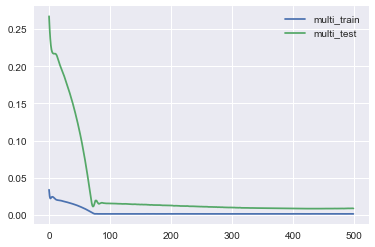

In [688]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

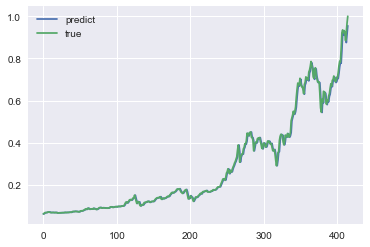

In [689]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [690]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#### RMSE

In [691]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 91.570


#### Plot line graph with actual price, predicted price with feature `Weighted Price`, predicted price with features `Volume` and `Weighted Price`

In [692]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

- LSTM with single feature of `Weighted Price` have RMSE of 160.999
- LSTM with features of `Volume(BTC)`, `Volume(Currency)` and `Weighted Price` have RMSE of 158.377
- LSTM with multi features shows more accurate results as show in line chart above

In [230]:
min_data = pd.read_csv(filepath_or_buffer="./coinbaseUSD_1-min_data_2014-12-01_to_2017-05-31.csv", index_col="Timestamp")
min_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1254594 entries, 1417411980 to 1496188800
Data columns (total 7 columns):
Open                 1148295 non-null float64
High                 1148295 non-null float64
Low                  1148295 non-null float64
Close                1148295 non-null float64
Volume_(BTC)         1148295 non-null float64
Volume_(Currency)    1148295 non-null float64
Weighted_Price       1148295 non-null float64
dtypes: float64(7)
memory usage: 76.6 MB


In [196]:
min_data.dropna(inplace=True)
min_data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.010000,3.00000,300.0
1417412400,300.0,300.0,300.0,300.0,0.010000,3.00000,300.0
1417415040,370.0,370.0,370.0,370.0,0.010000,3.70000,370.0
1417416600,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0
1417498140,377.0,377.0,377.0,377.0,0.010000,3.77000,377.0


In [197]:
new_date = pd.to_datetime(min_data.index, unit='s')

In [201]:
min_data['DateTime'] = new_date
min_data.set_index('DateTime', inplace=True)

In [202]:
min_data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
DateTime,,,,,,,
2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.010000,3.00000,300.0
2014-12-01 05:40:00,300.0,300.0,300.0,300.0,0.010000,3.00000,300.0
2014-12-01 06:24:00,370.0,370.0,370.0,370.0,0.010000,3.70000,370.0
2014-12-01 06:50:00,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0
2014-12-02 05:29:00,377.0,377.0,377.0,377.0,0.010000,3.77000,377.0


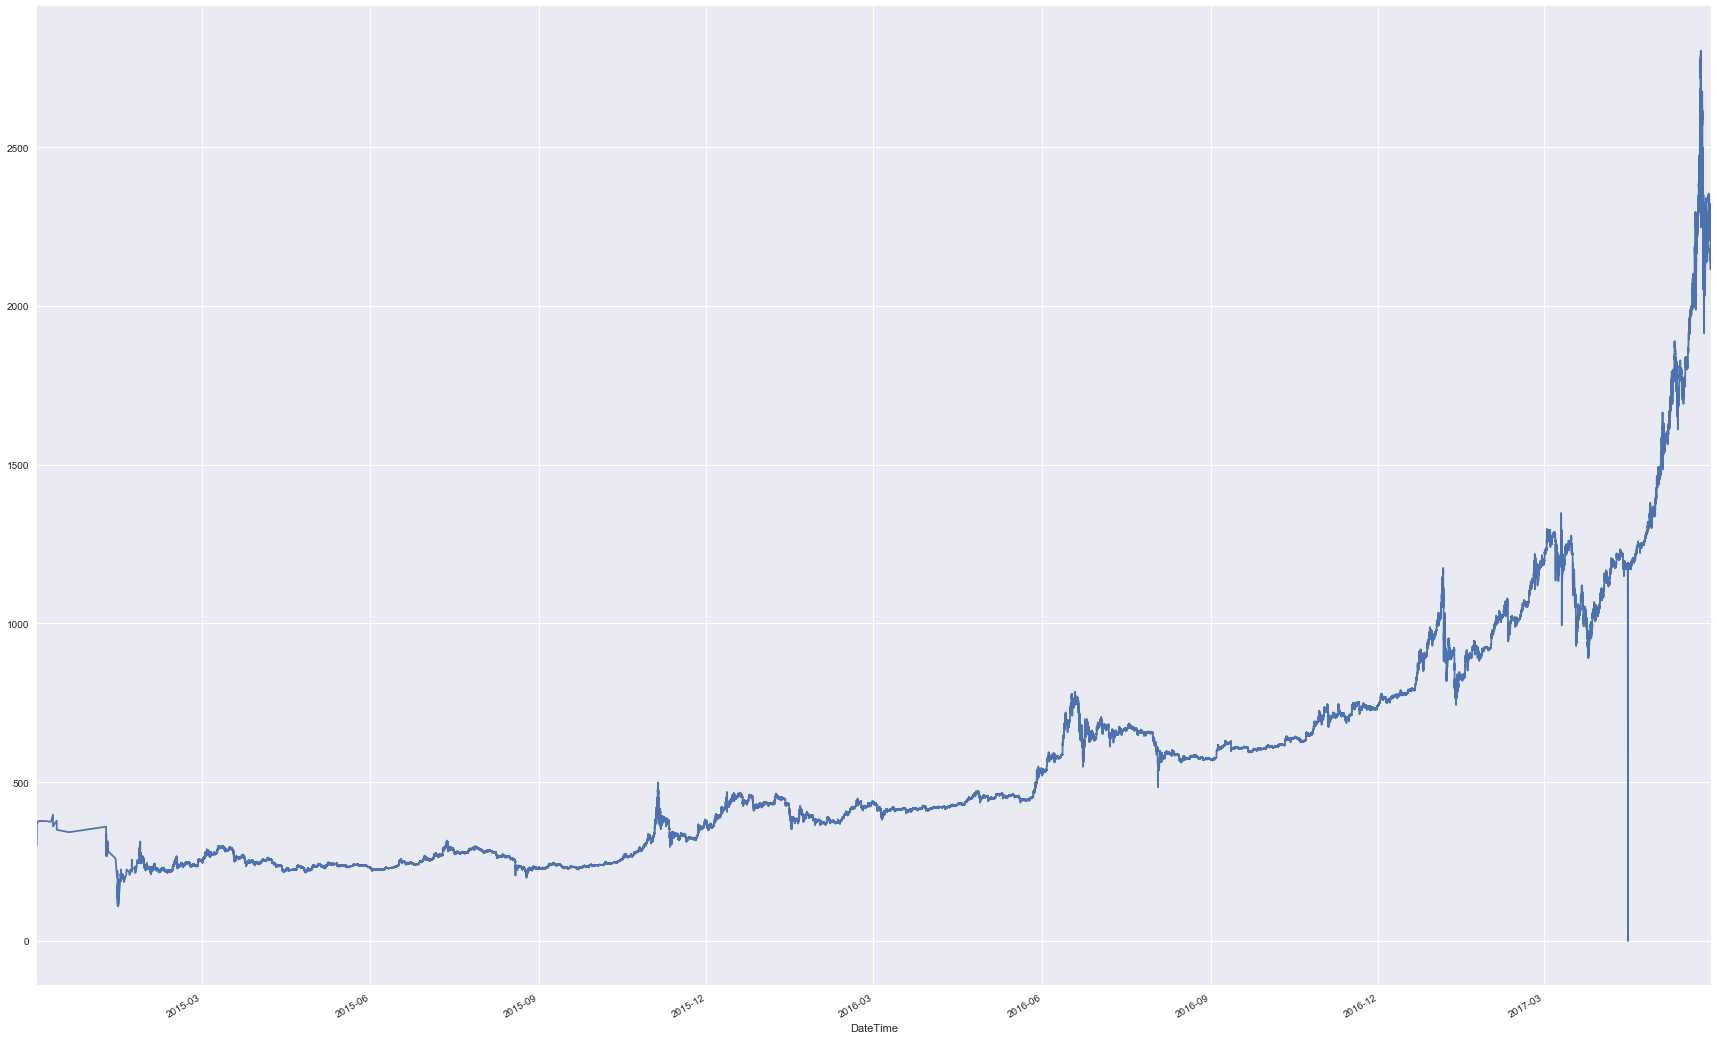

In [207]:
min_data['Weighted_Price'].plot(figsize=(30,20))

In [208]:
min_values = min_data['Weighted_Price'].values.reshape(-1,1)
min_values = min_values.astype('float32')
min_scaler = MinMaxScaler(feature_range=(0, 1))
min_scaled = min_scaler.fit_transform(min_values)

In [209]:
min_train_size = int(len(min_scaled) * 0.7)
min_test_size = len(min_scaled) - min_train_size
min_train, min_test = min_scaled[0:min_train_size,:], min_scaled[min_train_size:len(min_scaled),:]
print(len(min_train), len(min_test))

(803806, 344489)


In [210]:
look_back = 1
min_trainX, min_trainY = create_dataset(min_train, look_back)
min_testX, min_testY = create_dataset(min_test, look_back)

803805
344488


In [211]:
min_trainX = np.reshape(min_trainX, (min_trainX.shape[0], 1, min_trainX.shape[1]))
min_testX = np.reshape(min_testX, (min_testX.shape[0], 1, min_testX.shape[1]))

In [220]:
min_model = Sequential()
min_model.add(LSTM(10, input_shape=(min_trainX.shape[1], min_trainX.shape[2])))
min_model.add(Dense(1))
min_model.compile(loss='mae', optimizer='adam')
min_history = min_model.fit(min_trainX, min_trainY, epochs=50, batch_size=10000, validation_data=(min_testX, min_testY), verbose=2, shuffle=False)

Train on 803805 samples, validate on 344488 samples
Epoch 1/50
2s - loss: 0.0481 - val_loss: 0.1541
Epoch 2/50
1s - loss: 0.0554 - val_loss: 0.1446
Epoch 3/50
1s - loss: 0.0543 - val_loss: 0.1388
Epoch 4/50
1s - loss: 0.0519 - val_loss: 0.1305
Epoch 5/50
1s - loss: 0.0508 - val_loss: 0.1233
Epoch 6/50
1s - loss: 0.0490 - val_loss: 0.1154
Epoch 7/50
1s - loss: 0.0469 - val_loss: 0.1093
Epoch 8/50
1s - loss: 0.0454 - val_loss: 0.1038
Epoch 9/50
1s - loss: 0.0436 - val_loss: 0.0973
Epoch 10/50
1s - loss: 0.0415 - val_loss: 0.0920
Epoch 11/50
1s - loss: 0.0384 - val_loss: 0.0861
Epoch 12/50
1s - loss: 0.0362 - val_loss: 0.0820
Epoch 13/50
1s - loss: 0.0329 - val_loss: 0.0774
Epoch 14/50
1s - loss: 0.0320 - val_loss: 0.0729
Epoch 15/50
1s - loss: 0.0307 - val_loss: 0.0688
Epoch 16/50
1s - loss: 0.0289 - val_loss: 0.0645
Epoch 17/50
1s - loss: 0.0280 - val_loss: 0.0597
Epoch 18/50
1s - loss: 0.0263 - val_loss: 0.0530
Epoch 19/50
1s - loss: 0.0258 - val_loss: 0.0473
Epoch 20/50
1s - loss: 0.0

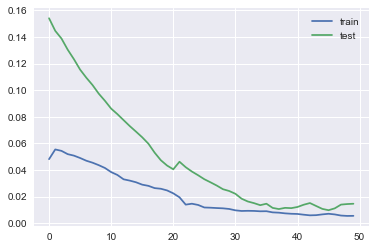

In [221]:
pyplot.plot(min_history.history['loss'], label='train')
pyplot.plot(min_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

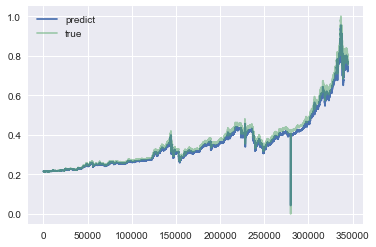

In [229]:
min_yhat = min_model.predict(min_testX)
pyplot.plot(min_yhat, label='predict')
pyplot.plot(min_testY, label='true', alpha=0.5)
pyplot.legend()
pyplot.show()


In [224]:
min_yhat_inverse = min_scaler.inverse_transform(min_yhat.reshape(-1, 1))
min_testY_inverse = min_scaler.inverse_transform(min_testY.reshape(-1, 1))

In [226]:
min_rmse = sqrt(mean_squared_error(min_testY_inverse, min_yhat_inverse))
print('Test RMSE: %.3f' % min_rmse)

Test RMSE: 48.884
